# ECG-ViEW 

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from sklearn.preprocessing import RobustScaler
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from keras import regularizers
from keras.utils import to_categorical
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from collections import Counter
import random

Using TensorFlow backend.


# CNN with Min Max Scaling, SMOTE 25%

In [2]:
# getting data into correct format for tensorflow backend
df_cnn_train = pd.read_csv("train.csv", header=None)
df_cnn_train = df_cnn_train.sample(frac=1)
df_cnn_test = pd.read_csv("test.csv", header=None)

y_cnn = np.array(df_cnn_train[11].values).astype(np.int8)
y_cnn=to_categorical(y_cnn)
x_cnn = np.array(df_cnn_train[list(range(11))].values)[..., np.newaxis]
y_cnn_test = np.array(df_cnn_test[11].values).astype(np.int8)
x_cnn_test = np.array(df_cnn_test[list(range(11))].values)[..., np.newaxis]

In [3]:
def get_model():
    # number of categories in our problem
    nclass = 2
    
    # shape of input
    inp = Input(shape=(11, 1))
    
    # 1 -- 16 filters
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Dropout(rate=0.1)(img_1) #to prevent overfitting

    # 2 -- 32 filters
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Dropout(rate=0.1)(img_1) #to prevent overfitting
    
    # 3 -- 64 filters
    img_1 = Convolution1D(64, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Dropout(rate=0.1)(img_1) #to prevent overfitting
    
    # 4 -- 256 filters 
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.1)(img_1) #to prevent overfitting

    # 5 -- Dense layers
    dense_1 = Dense(64, activation=activations.relu, name="dense_1", kernel_regularizer=regularizers.l2(l=0.1))(img_1)
    dense_1 = Dense(16, activation=activations.relu, name="dense_2", kernel_regularizer=regularizers.l2(l=0.1))(dense_1)
    dense_1 = Dense(nclass, activation=activations.softmax, name="dense_3_ecg_view")(dense_1)
    
    
    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()
    return model

In [4]:
model = get_model()
file_path = "baseline_cnn_ecgview_minmax.h5"

# checkpointing the model's weight based on the accuracy of the model
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# set early stopping based on accuracy improving or not. It stops after 5 epochs of no accuracy improvement
early = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1)

# reduces learning rate when a metric has stopped improving
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=7, verbose=2)

# defining the callbacks list to include the above parameters
callbacks_list = [checkpoint, early, redonplat]

# train the model
history = model.fit(x_cnn, y_cnn, epochs=1000, verbose=2, callbacks=callbacks_list, validation_split=0.1)
model.load_weights(file_path)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 11, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 16)             96        
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 16)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 32)             1568      
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 32)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 64)             6208      
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 64)             0   

 - 17s - loss: 0.3654 - acc: 0.8335 - val_loss: 0.3430 - val_acc: 0.8447

Epoch 00039: val_acc did not improve from 0.84549
Epoch 40/1000
 - 17s - loss: 0.3645 - acc: 0.8344 - val_loss: 0.3438 - val_acc: 0.8469

Epoch 00040: val_acc improved from 0.84549 to 0.84691, saving model to baseline_cnn_ecgview_minmax.h5
Epoch 41/1000
 - 17s - loss: 0.3647 - acc: 0.8348 - val_loss: 0.3418 - val_acc: 0.8470
 - 17s - loss: 0.3637 - acc: 0.8341 - val_loss: 0.3501 - val_acc: 0.8427

Epoch 00042: val_acc did not improve from 0.84697
Epoch 43/1000
 - 88s - loss: 0.3623 - acc: 0.8352 - val_loss: 0.3458 - val_acc: 0.8440

Epoch 00043: val_acc did not improve from 0.84697
Epoch 44/1000
 - 17s - loss: 0.3619 - acc: 0.8358 - val_loss: 0.3409 - val_acc: 0.8473

Epoch 00044: val_acc improved from 0.84697 to 0.84726, saving model to baseline_cnn_ecgview_minmax.h5
Epoch 45/1000
 - 256s - loss: 0.3622 - acc: 0.8350 - val_loss: 0.3472 - val_acc: 0.8435

Epoch 00045: val_acc did not improve from 0.84726
Epoch 46

In [7]:
## test the model
pred_test = model.predict(x_cnn_test)
pred_test = np.argmax(pred_test, axis=-1)

# get f1 score of the model & print it. The f1 score considers the precision & recall.
f1 = f1_score(y_cnn_test, pred_test, average="macro")
print("Test f1 score : %s "% f1)

# get ROC AUC score of the model & print it
roc = roc_auc_score(y_cnn_test, pred_test)
print("Test ROC AUC score : %s "% roc)

# get the accuracy and print it
acc = accuracy_score(y_cnn_test, pred_test)
print("Test accuracy score : %s "% acc)

Test f1 score : 0.844418495503996 
Test ROC AUC score : 0.8477347742811819 
Test accuracy score : 0.8602198841470623 


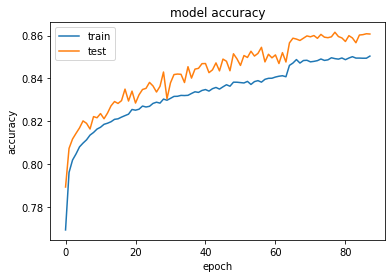

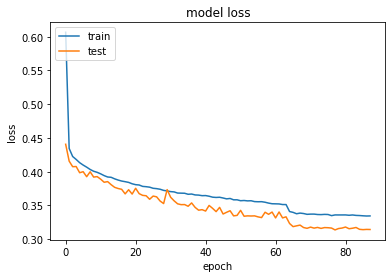

In [8]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
